In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from collections import defaultdict
import math
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (15, 8)
# histogram size
bin_size = 10

In [2]:
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

In [3]:
dates['Date'] = pd.to_datetime(dates[0])
y.set_index(dates['Date'],inplace=True)
X.set_index(dates['Date'],inplace=True)

In [4]:
avg_year = pd.read_csv('average_bi_yearly_733_flu_rate_4018.csv',header=None)

In [5]:
df1 = avg_year.copy()
#df1['rate'] = train1_y2
df1.head()

,0,1
0,2005-08-24,5.021790
1,2005-08-25,4.771060
2,2005-08-26,4.520357
3,2005-08-27,4.460002
4,2005-08-28,4.399650


In [6]:
df=df1.iloc[:,1:2].copy()
df3 = df[:3653].copy()
df4 = df[3653:].copy()

In [7]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 500 queries, ARIAMA only consider y, setting X has no effect
X = X.iloc[:, 0: 500]

# first with the last year as test
# use the last 365 of training set as validation set
test_size =365
val_size=365
length = X.shape[0]
train1_X = X[0:length-test_size*2]
val1_X = X[length-test_size*2:length-test_size]
train1_y = y[0:length-test_size*2]
val1_y = y[length-test_size*2:length-test_size]
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

#without validation set
train1_X2 = X[0:length-test_size]
train1_y2 = y[0:length-test_size]

# second with the last 2 year as test
test_size2 =365*2
train2_X = X[0:length-test_size2-val_size]
val2_X = X[length-test_size2-val_size:length-test_size2]
train2_y = y[0:length-test_size2-val_size]
val2_y = y[length-test_size2-val_size:length-test_size2]
test2_X = X[length-test_size2:length-test_size]
test2_y = y[length-test_size2:length-test_size]

#without validation set
train2_X2 = X[0:length-test_size2]
train2_y2 = y[0:length-test_size2]

y2 = y[:4018].copy()

print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)

X shape:  (4383, 500)   y shape:  (4383, 1)
train1 X: (3653, 500)  train1 y: (3653, 1)  Test1 X shape: (365, 500)  Test1 y shape: (365, 1)
train2 X: (3288, 500)  train2 y: (3288, 1)  Test2 X: (365, 500)  Test2 y: (365, 1)


In [8]:
df=df1.iloc[:,1:2].copy()
df.head()

,1
0,5.021790
1,4.771060
2,4.520357
3,4.460002
4,4.399650


In [9]:
## now model selection via AIC
def evaluate_arima_model2(dataset,X, p,d,q):
    # fit model
    model = ARIMA(dataset.values,exog=X,order=(p,d,q))
    model_fit = model.fit(disp=0)
  
    error = model_fit.aic
    return error


## tune the parameters by rmse
def evaluate_models2(dataset,X, p_values, d_values, q_values):
    best_score=1000000000
    p0=-1
    d0=-1
    q0=-1
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    aic = evaluate_arima_model2(dataset,X, p,d,q)
                    if aic < best_score:
                        best_score = aic
                        p0=p
                        d0=d
                        q0=q
                    print(p,',',d,',',q,' AIC:',aic)
                except:
                    continue
    print('Best ARIMA (',p0,',',d0,',',q0,') AIC:',best_score)


In [25]:
p_values = [2]
d_values = [1]
q_values = [14]
evaluate_models2(train2_y2,df3, p_values, d_values, q_values)

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2 , 1 , 14  AIC: 3368.8865965151463
Best ARIMA ( 2 , 1 , 14 ) AIC: 3368.8865965151463


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [27]:
p_values = [1]
d_values = [0]
q_values = [16]
evaluate_models2(train2_y2,df3, p_values, d_values, q_values)


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1 , 0 , 16  AIC: 3183.403711757466
Best ARIMA ( 1 , 0 , 16 ) AIC: 3183.403711757466


/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [10]:
model2 = sm.tsa.statespace.SARIMAX(endog=train2_y2.values,exog=df[:3653],order=[2,1,14])
model_fit2 = model2.fit(disp=0)
print(model_fit2.summary())

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 3653
Model:              SARIMAX(2, 1, 14)   Log Likelihood               -1516.266
Date:                Wed, 05 Sep 2018   AIC                           3068.533
Time:                        19:56:41   BIC                           3180.187
Sample:                             0   HQIC                          3108.295
                               - 3653                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
1              0.0315      0.039      0.801      0.423      -0.046       0.108
ar.L1          0.9579      0.101      9.439      0.000       0.759       1.157
ar.L2         -0.0013      0.101     -0.012      0.9

In [11]:
model2 = sm.tsa.statespace.SARIMAX(endog=train2_y2.values,exog=df[:3653],order=[1,2,14])
model_fit2 = model2.fit(disp=0)
print(model_fit2.summary())

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 3653
Model:              SARIMAX(1, 2, 14)   Log Likelihood               -1545.399
Date:                Wed, 05 Sep 2018   AIC                           3124.799
Time:                        19:57:22   BIC                           3230.245
Sample:                             0   HQIC                          3162.350
                               - 3653                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
1              0.0067      0.052      0.130      0.897      -0.095       0.108
ar.L1          0.0059      0.761      0.008      0.994      -1.485       1.497
ma.L1         -0.0058      2.942     -0.002      0.9

In [12]:
model2 = sm.tsa.statespace.SARIMAX(endog=train2_y2.values,exog=df[:3653],order=[2,1,15])
model_fit2 = model2.fit(disp=0)
print(model_fit2.summary())

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 3653
Model:              SARIMAX(2, 1, 15)   Log Likelihood               -1516.043
Date:                Wed, 05 Sep 2018   AIC                           3070.086
Time:                        19:58:03   BIC                           3187.944
Sample:                             0   HQIC                          3112.058
                               - 3653                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
1              0.0060      0.036      0.164      0.869      -0.065       0.077
ar.L1          0.9778      1.988      0.492      0.623      -2.918       4.874
ar.L2         -0.0197      1.907     -0.010      0.9

In [10]:
# Defien the mearure matrics, MAE, RMSE, CORR
# define three metrics: mean absolute error, root mean squared error and Pearson's correlation.
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)

train1 = train2_y2.values
test1 = test2_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:3653].copy()
df4 = df[3653:].copy()

history = [x for x in train1]
predict = list()
training_mod = sm.tsa.statespace.SARIMAX(endog =train1,
                                  exog=df3,
                                  trend='n', order=(2,1,14),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
training_res = training_mod.fit()

/home/yiyangsu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [15]:
train1 = train2_y2.values
test1 = test2_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:3653].copy()
df4 = df[3653:].copy()

history = [x for x in train1]
predict = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:3653+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,14),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4.iloc[[t]]
    output = model_fit.forecast(steps=1,exog=exog_test)
    yhat = output.values[0]
    print(yhat)
    predict.append(yhat)
    obs = test1[t]
    history.append(obs)
    history= history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict)
rmse1 = sqrt(mean_squared_error(test1, predict))

corr_y = test2_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

1.887750921068955
1
1.7870048303863713
2
1.7038385865317585
3
1.6576646253845555
4
1.8870614778578514
5
1.992100562432199
6
2.0820150273817064
7
2.1744537212172492
8
2.2721117531109045
9
2.3627776012211514
10
2.430083286733284
11
2.4269073785341133
12
2.4355555525392973
13
2.471503194163389
14
2.496248149608887
15
2.525299244677371
16
2.5500685187457166
17
2.537783460935515
18
2.8629045987471065
19
3.0153622574401835
20
3.1720235732787265
21
3.32689100536221
22
3.4855105929166115
23
3.634960396375704
24
3.7215432972271385
25
3.679107461015289
26
3.684112751503414
27
3.707450909872856
28
3.721499235682687
29
3.7441764869706406
30
3.753932153091688
31
3.735850574947444
32
3.9926624375192628
33
4.105511770251922
34
4.226122833647353
35
4.340615883717847
36
4.461804449597626
37
4.572224424830591
38
4.644255105110438
39
4.997205587007169
40
5.196718160653269
41
5.410896390391262
42
5.617166921716882
43
5.834495285381348
44
6.03545685719961
45
6.109242913061944
46
6.393203272277918
47
6.5588

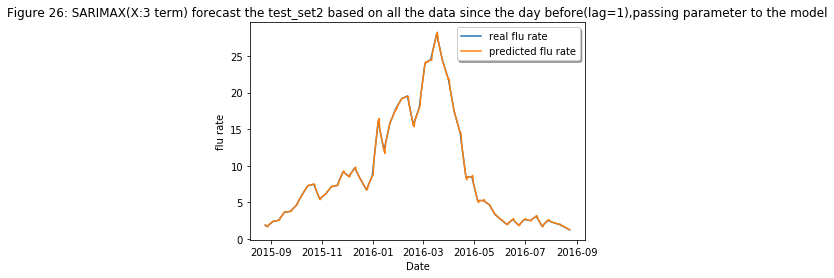

In [16]:
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],predict,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 26: SARIMAX(X:3 term) forecast the test_set2 based on all the data since the day before(lag=1),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [11]:
## lag=5
train1 = train2_y2.values[:3653-4]
test = y.values[3653-4:]
test1 = test2_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:3653].copy()
df4 = df[3653-4:].copy()


history = [x for x in train1]
predict2 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:3653-4+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,14),
                                     
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+5]
    output = model_fit.forecast(steps=5,exog=exog_test)
    yhat = output.values[4]
    print(yhat)
    predict2.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict2)
rmse1 = sqrt(mean_squared_error(test1, predict2))

corr_y = test2_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict2
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

2.779488731669703
1
2.13986637174279
2
2.0641803295023253
3
1.9762637955382054
4
1.9053133161373632
5
1.8526692213173348
6
1.8571684846854184
7
1.8246897351121834
8
2.591976766806917
9
2.718152628554177
10
2.7603900941587463
11
2.8305519048859535
12
2.898801093462776
13
2.947156267843886
14
3.009501197153842
15
2.8435042188636257
16
2.8108549966396503
17
2.8322109165173646
18
2.8134108770505626
19
2.8083611699792663
20
2.7951320308559797
21
2.79567857634773
22
3.75095315342721
23
3.8920800917902802
24
3.9756790297637035
25
4.059023379713165
26
4.140369454017718
27
4.2029854986533355
28
4.294718802320657
29
3.998289401858531
30
3.97604403595796
31
3.9771340922148486
32
3.950843819360955
33
3.941523959971843
34
3.905595054100865
35
3.9091453209795244
36
4.684959669845485
37
4.789117159890007
38
4.8653759001040475
39
4.927191677278598
40
4.999876757764599
41
5.046979186807363
42
5.1251316956445745
43
5.988717401649477
44
6.1592240378407705
45
6.242317835135523
46
6.308578946225926
47
6.38

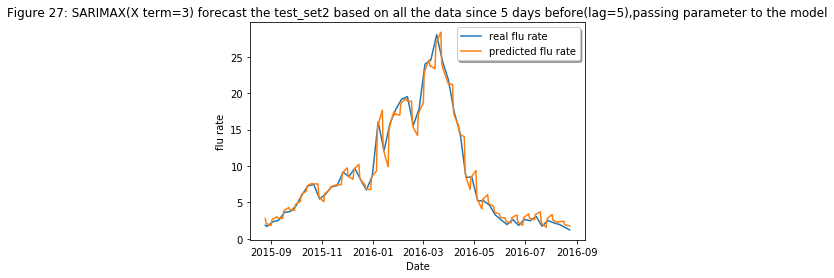

In [12]:
## lag=5
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],predict2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 27: SARIMAX(X term=3) forecast the test_set2 based on all the data since 5 days before(lag=5),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [13]:
## lag=10
train1 = train2_y2.values[:3653-9]
test = y.values[3653-9:]
test1 = test2_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:3653].copy()
df4 = df[3653-9:].copy()

history = [x for x in train1]
predict3 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:3653-9+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,14),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+10]
    output = model_fit.forecast(steps=10,exog=exog_test)
    yhat = output.values[9]
    print(yhat)
    predict3.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict3)
rmse1 = sqrt(mean_squared_error(test1, predict3))

corr_y = test2_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict3
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

3.6916939249975487
1
3.6641022343474967
2
3.6790617444634277
3
3.6746797908766475
4
3.5558174808032685
5
3.552015817687458
6
2.6717214942322145
7
2.6544274226112594
8
2.5689703548665723
9
2.519921186973957
10
2.5377179061955357
11
2.639865376223997
12
2.669813124654758
13
3.7578574816625623
14
3.8564900403119773
15
3.8722916571486246
16
3.915119659689412
17
3.906121891063901
18
3.8679802833801777
19
3.8606474977956937
20
3.550674948035592
21
3.460962215168682
22
3.51178616533699
23
3.4929449834145023
24
3.519234118363021
25
3.533795459938058
26
3.562943185561718
27
4.85866211270983
28
4.911296329228596
29
4.9868693250660785
30
5.050007373531237
31
5.044935236724454
32
5.014003185430289
33
5.032045746870197
34
4.528946533419934
35
4.460809144116057
36
4.485250505751599
37
4.458101128258418
38
4.492744227283455
39
4.485994095924387
40
4.535296119010282
41
5.604061737271913
42
5.646366502150802
43
5.719883772973589
44
5.763369912187514
45
5.765052902430683
46
5.73356538899138
47
5.7503004

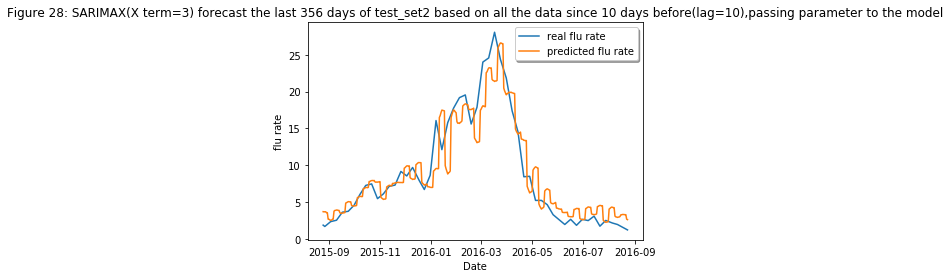

In [14]:
# visualize lag=10
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],predict3,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 28: SARIMAX(X term=3) forecast the last 356 days of test_set2 based on all the data since 10 days before(lag=10),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [15]:
## lag=14
train1 = train2_y2.values[:3653-13]
test = y.values[3653-13:]
test1 = test2_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:3653].copy()
df4 = df[3653-13:].copy()

history = [x for x in train1]
predict4 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:3653-13+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,14),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+14]
    output = model_fit.forecast(steps=14,exog=exog_test)
    yhat = output.values[13]
    print(yhat)
    predict4.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict4)
rmse1 = sqrt(mean_squared_error(test1, predict4))

corr_y = test2_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict4
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

3.7273011317203784
1
4.052415574107006
2
4.060453570568801
3
4.418235375151359
4
4.445945145864617
5
4.390026252248799
6
4.382295570943451
7
4.377432382115587
8
4.258864241845462
9
4.2659776851558835
10
3.360943598292801
11
3.4238016944967287
12
3.389251558802989
13
3.392386953129367
14
3.410548864728096
15
3.5063665269190776
16
3.5324168619187324
17
4.6555537657104535
18
4.680729745152958
19
4.622321021819141
20
4.59854557954247
21
4.589555429005231
22
4.555602299866105
23
4.544816532842522
24
4.228963680717622
25
4.160316417368488
26
4.236977231269753
27
4.242223694293157
28
4.268308847157587
29
4.278725415584373
30
4.307942384359613
31
5.650374960019462
32
5.617002656481387
33
5.61036107061953
34
5.596636199108351
35
5.592788395934096
36
5.5639559165429
37
5.5793506249146345
38
5.059791373939908
39
5.0234737108843435
40
5.082316897325597
41
5.089699068466013
42
5.125664953029498
43
5.115135238288652
44
5.1674406683740095
45
6.273387445996913
46
6.245942536597871
47
6.250070576012131

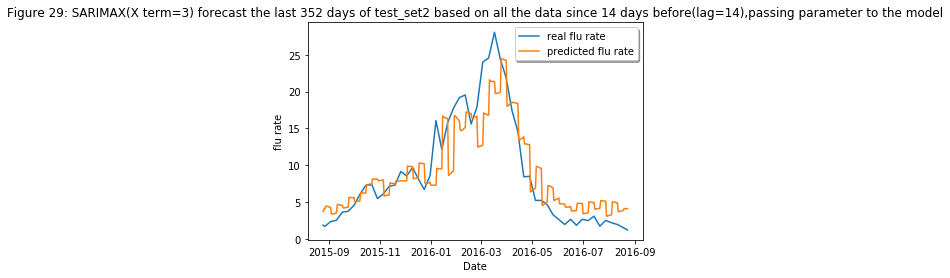

In [16]:
# visualize lag=14
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],predict4,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 29: SARIMAX(X term=3) forecast the last 352 days of test_set2 based on all the data since 14 days before(lag=14),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

In [17]:
## lag=28
train1 = train2_y2.values[:3653-27]
test = y.values[3653-27:]
test1 = test2_y.values

df=df1.iloc[:,1:2].copy()
df3 = df[:3653].copy()
df4 = df[3653-27:].copy()


history = [x for x in train1]
predict5 = list()
count=0

for t in range(len(test1)):
    exog_train= df[t:3653-27+t]
    model = sm.tsa.statespace.SARIMAX(endog =history,
                                      exog=exog_train,
                                      trend='n', order=(2,1,14),
                                      
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    model_fit = model.filter(training_res.params)
    exog_test =df4[t:t+28]
    output = model_fit.forecast(steps=28,exog=exog_test)
    yhat = output.values[27]
    print(yhat)
    predict5.append(yhat)
    obs = test[t]
    history.append(obs)
    history = history[1:]
    count=count+1
    print(count)

mae1 = mean_absolute_error(test1, predict5)
rmse1 = sqrt(mean_squared_error(test1, predict5))

corr_y = test2_y.copy()
corr_y['y_act'] = test1
corr_y['y_pred']= predict5
corr2 = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]


print(mae1,rmse1,corr2)

5.920052510166691
1
5.721573440047394
2
5.739047928334647
3
5.93436784323923
4
5.953693764877896
5
5.919006189891628
6
5.909467338892056
7
5.905029896346096
8
5.994586780280241
9
5.996485456628182
10
5.994381967808828
11
6.021457175424244
12
5.990709592368805
13
5.981687897587835
14
5.982211424576375
15
6.17624741829922
16
6.180509968158543
17
6.393138965548373
18
6.411720145175845
19
6.3828463642081426
20
6.380540291181759
21
6.379842761132451
22
6.311879603515394
23
6.306357018205237
24
5.777834544657659
25
5.808897870794402
26
5.789183071057187
27
5.792236912480904
28
5.805347324451592
29
5.8631071736215805
30
5.879042091172535
31
6.541816092427379
32
6.558040045549006
33
6.525254175215722
34
6.513888361512666
35
6.512628596567135
36
6.494584216685927
37
6.480846853567465
38
6.298138243513169
39
6.259515078418227
40
6.306536149619453
41
6.3105498460430365
42
6.329448691281107
43
6.337596184159219
44
6.362266828379677
45
7.155111956151651
46
7.139736821925179
47
7.137003383571394
48


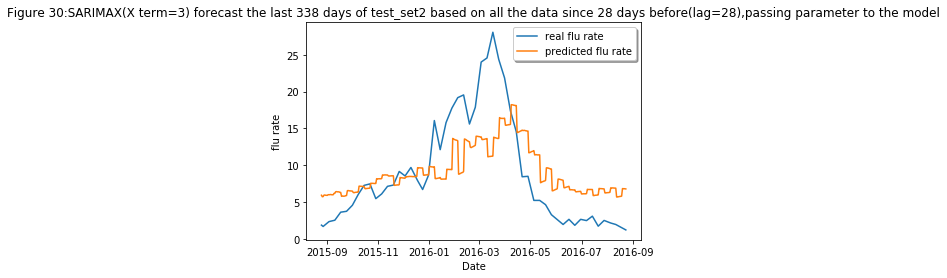

In [18]:
# visualize
date = pd.date_range('20050824',periods=4018)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values
fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],predict5,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)

plt.title("Figure 30:SARIMAX(X term=3) forecast the last 338 days of test_set2 based on all the data since 28 days before(lag=28),passing parameter to the model")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()